In [1]:
#TEST IMPORTS
import numpy as np
from ours.V3_3 import Ours_V3_3 
from ours.V1 import Ours_V1
from cscg.cscg import CHMM, datagen_structured_obs_room

from envs.minigrid import GridWorldEnv
from visualisation_tools import *
import time
import pickle

## MINIGRID SETUP

In [2]:
output= np.zeros((2 + 1))

output.reshape(1,3)

array([[0., 0., 0.]])

In [3]:
# rooms = np.array(
#     [
#         [0, 0, 1],
#         [2, 0, 4],
#         [3, 3, 3],
#     ]
# )
rooms = np.array(
            [
                [0, 1, 2],
                [5, 4, 3],
                [6, 7, 8],
            ]
        ) 
# rooms = np.array(
#     [
#         [0, 0, 1, 4],
#         [2, 0, 1, 3],
#         [3, 3, 3, 0],
#     ]
# ) #3x4 rooms, 1 ob per room

# rooms = np.array(
#     [
#         [0, 1],
#         [2, 3]
#     ]
# )

In [4]:
#ASSIGN COLORS TO ROOMS IDS

custom_colors = (
    np.array(
        [
            [255, 0, 0],
            [0, 255, 0],
            [50,50, 255],
            [112, 39, 195],
            [255, 255, 0],
            [100, 100, 100],
            [0, 0, 0],
            [255, 255, 255],
            
        ]
    )
    / 256
)

cmap = create_custom_cmap(custom_colors[:len(np.unique(rooms))])

In [5]:
actions = {'LEFT':0, 'RIGHT':1,'UP':2, 'DOWN':3, 'STAY':4}
desired_state_mapping = {(i * rooms.shape[1] + j): (i, j) for i in range(rooms.shape[0]) for j in range(rooms.shape[1])}

In [6]:
def define_perfect_B(env,rooms, actions):
    """ The perfect B is defined as B[next_state, prev_state, action]"""
    #perfect B for this room config
    desired_state_mapping = {(i * rooms.shape[1] + j): (i, j) for i in range(rooms.shape[0]) for j in range(rooms.shape[1])}
    P = {}
    dim = rooms.shape
    for state_index, xy_coordinates in desired_state_mapping.items():
        P[state_index] = {a : [] for a in range(len(actions))}
        for action in actions.values():
            pose = env.next_p_given_a_known_env(xy_coordinates, action)
            #print('action', action, 'state coordinates', state_index, xy_coordinates, 'next pose', pose)
            next_state_idx = next(key for key, value in desired_state_mapping.items() if value == pose)
            P[state_index][action] = next_state_idx


    num_states = len(desired_state_mapping)
    B = np.zeros([num_states, num_states, len(actions)])
    # print(B.shape)
    for s in range(num_states):
        # print('s', s, perfect_state_mapping[s])
        for a in range(len(actions)):
            ns = int(P[s][a])
            # print('ps', s, 'a', a, 'ns',ns)
            B[ns, s, a] = 1
    return B, desired_state_mapping

def agent_B_match_ideal_B_v2(agent_B, perfect_B, agent_state_mapping, desired_state_mapping, actions, tolerance_margin = 0.3):
    """Check if the values == 1 in perfect_B are filled with values relatively close at tolerance level"""
    room_valid_state_agent= { k:v for k, v in agent_state_mapping.items() if k in desired_state_mapping.values() }

    if len(room_valid_state_agent) < len(desired_state_mapping):
        return False
    rearranged_B = B_to_ideal_B(agent_B, actions,desired_state_mapping, room_valid_state_agent)
    rearranged_B = rearranged_B[:len(desired_state_mapping),:len(desired_state_mapping),:]
    if rearranged_B.shape != perfect_B.shape:
        raise 'rearranged_B.shape should match B.shape'
    non_zero_mask = perfect_B > 0
    matching_indices = np.where(non_zero_mask & (np.abs(perfect_B - rearranged_B) <= tolerance_margin))
    match_result = np.array_equal(np.array(matching_indices) ,np.array(np.where(non_zero_mask)))
    
    return match_result

In [7]:
#TEST MODELS INIT

env = GridWorldEnv('grid_3x3', actions,\
                        max_steps=300, goal=-1)
start_pose = (0,0)
obs,_ = env.reset(start_pose)
ob, pose = obs
start_state_idx = env.get_state(start_pose)

goal = 1
print(env.rooms)


[[0 1 2]
 [5 4 3]
 [6 7 8]]


## LOAD MODELS

In [8]:
def load_object(load_path):            
    with open(load_path, "rb") as inp:
        agent = pickle.load(inp)
    return agent


In [9]:
from bokeh.plotting import show, output_file, figure
from bokeh.layouts import column, row
from bokeh.models import Div
from bokeh.models.widgets import Panel, Tabs

In [10]:
import imageio
def generate_run_report(run_logs, store_path):
    figures = []

    state_beliefs = [log["qs"] for log in run_logs["agent_info"]]

    # Trajectory gif
    gif_path = store_path / "navigate.gif"
    imageio.mimsave(gif_path, run_logs["frames"], 'GIF', duration=500)

    h, w, _ = run_logs["frames"][0].shape
    h = max(128, h)
    w = max(128, w)
    gif = Div(
        text=f"<img src={str(gif_path)} width={w} height={h}></img>",
        width=w,
        height=h,
    )
    figures.append(gif)
    # Entropy plot
    entropies = [entropy(s) for s in state_beliefs]
    fig_entropy = figure(title="Entropy over full state belief", plot_height=200)
    fig_entropy.line(np.arange(len(entropies)), entropies)
    figures.append(fig_entropy)

    # Bayesian Surprise
    surprises = [np.nan_to_num(log["bayesian_surprise"]) for log in run_logs["agent_info"]]
    fig_surprise = figure(title="Bayesian Surprise", plot_height=200)
    fig_surprise.line(np.arange(len(surprises)), surprises)
    figures.append(fig_surprise)

    return row(*figures)

In [11]:
output_file("report.html")

generate_run_report(data_infos, spath)
#show(layout)

NameError: name 'data_infos' is not defined

In [ ]:
# from bokeh.models.widgets import Image
from bokeh.io import curdoc

pages = []

spath = get_store_path('cscg', 'test')

spath.mkdir(exist_ok=True, parents=True)


run_logs = {'here':[1,2,3,3,4]}

run_logs['test'] =  ['mia' for _ in run_logs["here"]]

run_logs_df = pd.DataFrame.from_dict(run_logs)

codebook_path = spath / "codebook.png"
n = int(np.ceil(len(run_logs_df['here']) / 10))
w, h = 1000, n *100
# Create an Image widget to display the codebook image
#codebook_img = Div(text=f"<img src='{str(codebook_path)}' width='{w}' height='{h}'>")

codebook = Div(
    text=f"<img src={str(codebook_path)} width={w} height={h}></img>",
    width=w,
    height=h,
)

page = column(
    Div(text=f"{'tutu'}-{'big'}"),
    generate_run_report(data_infos, spath),
    #codebook_img
)
pages.append(
    Panel(child=page, title=f"{'cscg'}: Trial {'1'}")
)

title_path = spath / "cscg_test.html"
output_file(
        title_path,
        title='test_cscg'.capitalize(),
    )

title = Div(text=f"<h1>Report for {'test_cscg'}</h1>")

#curdoc().add_root(column(title, Tabs(tabs=pages)))
show(column(title, codebook, Tabs(tabs=pages)))

run_logs_df.to_csv(spath / f"{'test'}.csv")

## OURS

### colour and pose as ob

In [ ]:
ours_v3_3 = Ours_V3_3(num_obs=2, num_states=2, dim=2, observations=[ob,start_pose], learning_rate_pB=3.0, actions= actions)
#ours_v1 = Ours_V1(num_obs=2, num_states=2, observations=[ob,start_state_idx], learning_rate_pB=3.0, actions= actions)
action_hist = []

 __ 
time 0 believed Qs: [1. 0.]
action taken: 1 pose: (0, 1) ,ob: 1
prior on believed state [0. 1.]
update_B: a 1 qs[factor] [0. 1.] qs_prev[factor] [1. 0.]
update_B: a 0 qs[factor] [1. 0.] qs_prev[factor] [0. 1.]
Ghost nodes process:
a 1 n pose (0, 2) 2
update_B: a 1 qs[factor] [0.016 0.016 0.968] qs_prev[factor] [0. 1. 0.]
update_B: a 2 qs[factor] [0. 1. 0.] qs_prev[factor] [0. 1. 0.]
a 3 n pose (1, 1) 3
update_B: a 3 qs[factor] [0.042 0.042 0.249 0.667] qs_prev[factor] [0. 1. 0. 0.]
 __ 
time 1 believed Qs: [0. 1. 0. 0.]
action taken: 3 pose: (1, 1) ,ob: 4
prior on believed state [0.031 0.031 0.053 0.885]
update_B: a 3 qs[factor] [0.031 0.031 0.053 0.885] qs_prev[factor] [0. 1. 0. 0.]
update_B: a 2 qs[factor] [0. 1. 0. 0.] qs_prev[factor] [0.031 0.031 0.053 0.885]
Ghost nodes process:
a 0 n pose (1, 0) 4
update_B: a 0 qs[factor] [0.013 0.013 0.013 0.015 0.946] qs_prev[factor] [0.01  0.01  0.017 0.962 0.   ]
a 1 n pose (1, 2) 5
update_B: a 1 qs[factor] [0.069 0.069 0.069 0.071 0.055

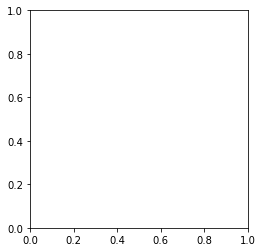

In [ ]:
# #RUN oursV3.3 EXPLO
T= 3
import warnings
warnings.filterwarnings('ignore')
perfect_B, desired_state_mapping = define_perfect_B(env,rooms, actions)
pose = start_pose
ours_v3_3.explo_oriented_navigation()
data_infos = {'frames':[get_frame(env, pose)], 'agent_info':[]}
policy = [1,1,3,0]
for t in range(0,T):
    print(' __ ')
    print('time', t, 'believed Qs:',ours_v3_3.get_current_belief()[0].round(3))
    action, info = ours_v3_3.infer_action()
    #action = policy[t]
    # ours_v3_3.agent.action = np.array([action])
    # ours_v3_3.agent.step_time()
    action_hist.append(action)
    obs, _,_,_ = env.step(action, pose)
    ob, pose = obs
    data = {}
    data_infos['frames'].append(get_frame(env, pose))
    # data_infos['agent_info'].append(info)
    
    next_possible_actions = env.get_next_possible_motions(pose)
    print('action taken:',int(action),'pose:',pose,',ob:', ob)
    ours_v3_3.agent_step_update(action,[ob,pose],next_possible_actions)
    
    # print('after belief update')
    # print('A colours:\n',ours_v3_3.agent.A[0].round(3))
    # print('A poses:\n',ours_v3_3.agent.A[1].round(3))
    # print('B')
    # print_transitions(ours_v3_3.agent.B, actions)
    
    if agent_B_match_ideal_B_v2(ours_v3_3.get_B(), perfect_B, \
                ours_v3_3.get_agent_state_mapping(), \
                desired_state_mapping, actions, tolerance_margin= 0.4):
            print('Transition matrix is good')
            break

### colour as ob, pose inferred

In [ ]:
ours_v3_3 = Ours_V3_3(num_obs=2, num_states=2, dim=2, observations=[ob], learning_rate_pB=3.0, actions= actions)
#ours_v1 = Ours_V1(num_obs=2, num_states=2, observations=[ob,start_state_idx], learning_rate_pB=3.0, actions= actions)
action_hist = []
start_pose = (0,0)
obs,_ = env.reset(start_pose)
ob, pose = obs

 __ 
time 0 believed Qs: [1. 0.]
action taken: 1 pose: (0, 1) ,ob: 1
prior on believed state [0. 1.]
update_B: a 1 qs[factor] [0. 1.] qs_prev[factor] [1. 0.]
update_B: a 0 qs[factor] [1. 0.] qs_prev[factor] [0. 1.]
Ghost nodes process:
a 0 n pose (0, 0) 1
update_B: a 0 qs[factor] [0. 1.] qs_prev[factor] [0. 1.]
new n_pose
a 1 n pose (0, 2) 2
update_B: a 1 qs[factor] [0.016 0.016 0.968] qs_prev[factor] [0. 1. 0.]
update_B: a 2 qs[factor] [0. 1. 0.] qs_prev[factor] [0. 1. 0.]
new n_pose
a 3 n pose (1, 1) 3
update_B: a 3 qs[factor] [0.074 0.074 0.186 0.667] qs_prev[factor] [0. 1. 0. 0.]
a 4 n pose (0, 1) 3
update_B: a 4 qs[factor] [0.119 0.119 0.3   0.462] qs_prev[factor] [0. 1. 0. 0.]
agent_internal_pose [0, 1, 3, 4] (0, 1)
 __ 
time 1 believed Qs: [0. 1. 0. 0.]
action taken: 3 pose: (1, 1) ,ob: 4
prior on believed state [0.064 0.064 0.058 0.815]
update_B: a 3 qs[factor] [0.064 0.064 0.058 0.815] qs_prev[factor] [0. 1. 0. 0.]
update_B: a 2 qs[factor] [0. 1. 0. 0.] qs_prev[factor] [0.064 

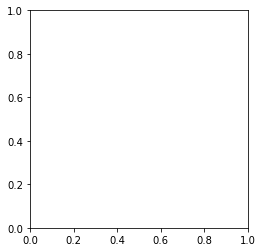

In [ ]:
# #RUN oursV3.3 EXPLO
T= 35
import warnings
warnings.filterwarnings('ignore')
perfect_B, desired_state_mapping = define_perfect_B(env,rooms, actions)
pose = start_pose
ours_v3_3.explo_oriented_navigation()
data_infos = {'frames':[get_frame(env, pose)], 'agent_info':[]}
policy = [1,1,3,0]
next_possible_actions = env.get_next_possible_motions(pose)
for t in range(0,T):
    print(' __ ')
    print('time', t, 'believed Qs:',ours_v3_3.get_current_belief()[0].round(3))
    action, info = ours_v3_3.infer_action(next_possible_actions=next_possible_actions)
    #action = policy[t]
    # ours_v3_3.agent.action = np.array([action])
    # ours_v3_3.agent.step_time()
    action_hist.append(action)
    obs, _,_,_ = env.step(action, pose)
    ob, pose = obs
    data = {}
    data_infos['frames'].append(get_frame(env, pose))
    # data_infos['agent_info'].append(info)
    
    next_possible_actions = env.get_next_possible_motions(pose)
    print('action taken:',int(action),'pose:',pose,',ob:', ob)
    ours_v3_3.agent_step_update(action,[ob],next_possible_actions)
    print('agent_internal_pose',next_possible_actions, ours_v3_3.current_pose)
    if ours_v3_3.current_pose != pose:
          print("POSE ERROR")
          break
    # print('after belief update')
    # print('A colours:\n',ours_v3_3.agent.A[0].round(3))
    # print('A poses:\n',ours_v3_3.agent.A[1].round(3))
    # print('B')
    # print_transitions(ours_v3_3.agent.B, actions)
    
    if agent_B_match_ideal_B_v2(ours_v3_3.get_B(), perfect_B, \
                ours_v3_3.get_agent_state_mapping(), \
                desired_state_mapping, actions, tolerance_margin= 0.4):
            print('Transition matrix is good')
            break

### colour as ob

In [21]:
from ours.pymdp import utils, control, inference
from ours.pymdp.maths import spm_dot
from envs.modules import next_p_given_a, reverse_action

In [ ]:
empirical_prior = control.get_expected_states(
                    ours_v3_3.agent.qs, ours_v3_3.agent.B, np.array([2]).reshape(1, -1) #type: ignore
                )[0]

print('empirical prior',empirical_prior[0].round(3))
qs = inference.update_posterior_states(
            ours_v3_3.agent.A,
            [0],
            empirical_prior,
            **ours_v3_3.agent.inference_params
            )

print('qs',qs[0].round(3))



array([0.338, 0.23 , 0.247, 0.001, 0.   , 0.   , 0.034, 0.054, 0.025,
       0.012, 0.017, 0.017, 0.005, 0.013, 0.007])

In [ ]:
latest_obs = [0,2,3,3]
latest_actions = [np.array([0]),np.array([3]),np.array([3]),np.array([1])]

prior = np.array(np.array([0.25, 0.5 , 0.25, 0.001, 0.   , 0.   , 0.034, 0.054, 0.025,
       0.012, 0.017, 0.017, 0.005, 0.013, 0.007]))

In [ ]:
p_a = np.stack(latest_actions,0)
policies = np.array([np.array([2])])
print(p_a.shape, policies.shape)
for policy in policies:
    print(policy.shape)
    u = np.vstack((p_a, policy))
    print(u)
    break

(4, 1) (1, 1)
(1,)
[[0]
 [3]
 [3]
 [1]
 [2]]


In [22]:
# if len(self.prev_obs) > self.inference_horizon:
#     latest_obs = self.prev_obs[-self.inference_horizon:]
#     latest_actions = self.prev_actions[-(self.inference_horizon-1):]
# else:
#     latest_obs = self.prev_obs
#     latest_actions = self.prev_actions
policies = np.array([np.array([2])])
qs, F = inference.update_posterior_states_full(
    ours_v3_3.agent.A,
    ours_v3_3.agent.B,
    latest_obs,
    policies, 
    latest_actions, 
    prior = prior, 
    policy_sep_prior = ours_v3_3.agent.edge_handling_params['policy_sep_prior'],
    #**ours_v3_3.agent.inference_params
)


NameError: name 'latest_obs' is not defined

In [20]:
for q_idx in range(qs[0].shape[0]):
    print('step', q_idx+1)
    print(qs[0][q_idx][0].round(3))

NameError: name 'qs' is not defined

In [14]:
from ours.pymdp import maths
def run_mmp(
    lh_seq, B, policy, prev_actions=None, prior=None, num_iter=10, grad_descent=True, tau=0.25, last_timestep = False):
    """
    Marginal message passing scheme for updating marginal posterior beliefs about hidden states over time, 
    conditioned on a particular policy.

    Parameters
    ----------
    lh_seq: ``numpy.ndarray`` of dtype object
        Log likelihoods of hidden states under a sequence of observations over time. This is assumed to already be log-transformed. Each ``lh_seq[t]`` contains
        the log likelihood of hidden states for a particular observation at time ``t``
    B: ``numpy.ndarray`` of dtype object
        Dynamics likelihood mapping or 'transition model', mapping from hidden states at ``t`` to hidden states at ``t+1``, given some control state ``u``.
        Each element ``B[f]`` of this object array stores a 3-D tensor for hidden state factor ``f``, whose entries ``B[f][s, v, u]`` store the probability
        of hidden state level ``s`` at the current time, given hidden state level ``v`` and action ``u`` at the previous time.
    policy: 2D ``numpy.ndarray``
        Matrix of shape ``(policy_len, num_control_factors)`` that indicates the indices of each action (control state index) upon timestep ``t`` and control_factor ``f` in the element ``policy[t,f]`` for a given policy.
    prev_actions: ``numpy.ndarray``, default None
        If provided, should be a matrix of previous actions of shape ``(infer_len, num_control_factors)`` that indicates the indices of each action (control state index) taken in the past (up until the current timestep).
    prior: ``numpy.ndarray`` of dtype object, default None
        If provided, the prior beliefs about initial states (at t = 0, relative to ``infer_len``). If ``None``, this defaults
        to a flat (uninformative) prior over hidden states.
    numiter: int, default 10
        Number of variational iterations.
    grad_descent: Bool, default True
        Flag for whether to use gradient descent (free energy gradient updates) instead of fixed point solution to the posterior beliefs
    tau: float, default 0.25
        Decay constant for use in ``grad_descent`` version. Tunes the size of the gradient descent updates to the posterior.
    last_timestep: Bool, default False
        Flag for whether we are at the last timestep of belief updating
        
    Returns
    ---------
    qs_seq: ``numpy.ndarray`` of dtype object
        Posterior beliefs over hidden states under the policy. Nesting structure is timepoints, factors,
        where e.g. ``qs_seq[t][f]`` stores the marginal belief about factor ``f`` at timepoint ``t`` under the policy in question.
    F: float
        Variational free energy of the policy.
    """

    # window
    past_len = len(lh_seq)
    future_len = policy.shape[0]
    print('last_timestep', last_timestep,future_len, past_len)
    if last_timestep:
        infer_len = past_len + future_len - 1
    else:
        infer_len = past_len + future_len
    
    future_cutoff = past_len + future_len - 2

    # dimensions
    _, num_states, _, num_factors = utils.get_model_dimensions(A=None, B=B)

    # beliefs
    qs_seq = utils.obj_array(infer_len)
    for t in range(infer_len):
        qs_seq[t] = utils.obj_array_uniform(num_states)

    # last message
    qs_T = utils.obj_array_zeros(num_states)

    # prior
    if prior is None:
        prior = utils.obj_array_uniform(num_states)

    # transposed transition
    trans_B = utils.obj_array(num_factors)
        
    for f in range(num_factors):
        trans_B[f] = maths.spm_norm(np.swapaxes(B[f],0,1))

    if prev_actions is not None:
        policy = np.vstack((prev_actions, policy))

        #print('policy', policy)
    for itr in range(num_iter):
        #print()
        #print('iteration', itr)
        F = 0.0 # reset variational free energy (accumulated over time and factors, but reset per iteration)
        for t in range(infer_len):
            for f in range(num_factors):
                # likelihood
                if t < past_len:
                    lnA = maths.spm_log_single(spm_dot(lh_seq[t], qs_seq[t], [f]))
                else:
                    lnA = np.zeros(num_states[f])
                #print('inference step',t,'factor',f,'LIKELIHOOD', lnA, 'past_len', past_len)
                # past message
                if t == 0:
                    lnB_past = maths.spm_log_single(prior[f])
                else:
                    past_msg = B[f][:, :, int(policy[t - 1, f])].dot(qs_seq[t - 1][f])
                    lnB_past = maths.spm_log_single(past_msg)
               # print('inference step',t,'action',policy[t - 1, f],'PAST T', lnB_past)
                # future message
                if t >= future_cutoff:
                    lnB_future = qs_T[f]
                    #print('t and future_cutoff', t, future_cutoff)
                else:
                    future_msg = trans_B[f][:, :, int(policy[t, f])].dot(qs_seq[t + 1][f])
                    lnB_future = maths.spm_log_single(future_msg)
                    #print('qs_seq[t + 1][f]', qs_seq[t + 1][f])
                #print('inference step',t,'action',policy[t, f],'EXPECTED FUTURE T', lnB_future)
                # inference
                if grad_descent:
                    sx = qs_seq[t][f] # save this as a separate variable so that it can be used in VFE computation
                    lnqs = maths.spm_log_single(sx)
                    coeff = 1 if (t >= future_cutoff) else 2
                    err = (coeff * lnA + lnB_past + lnB_future) - coeff * lnqs
                    lnqs = lnqs + tau * (err - err.mean())
                    qs_seq[t][f] = maths.softmax(lnqs)
                    if (t == 0) or (t == (infer_len-1)):
                        F += sx.dot(0.5*err)
                    else:
                        F += sx.dot(0.5*(err - (num_factors - 1)*lnA/num_factors)) # @NOTE: not sure why Karl does this in SPM_MDP_VB_X, we should look into this
                else:
                    qs_seq[t][f] = maths.softmax(lnA + lnB_past + lnB_future)
            
            if not grad_descent:

                if t < past_len:
                    F += maths.calc_free_energy(qs_seq[t], prior, num_factors, likelihood = maths.spm_log_single(lh_seq[t]) )
                else:
                    F += maths.calc_free_energy(qs_seq[t], prior, num_factors)

    return qs_seq, F

In [15]:
def update_posterior_states_full(
    A,
    B,
    prev_obs,
    policies,
    prev_actions=None,
    prior=None,
    policy_sep_prior = True,
    **kwargs,
):

    num_obs, num_states, num_modalities, num_factors = utils.get_model_dimensions(A, B)
    
    prev_obs = utils.process_observation_seq(prev_obs, num_modalities, num_obs)
   
    lh_seq = inference.get_joint_likelihood_seq(A, prev_obs, num_states)
    print('update_posterior-state: lh_seq', lh_seq)

    if prev_actions is not None:
        prev_actions = np.stack(prev_actions,0)

    qs_seq_pi = utils.obj_array(len(policies))
    F = np.zeros(len(policies)) # variational free energy of policies

    for p_idx, policy in enumerate(policies):
            
            # get sequence and the free energy for policy
            qs_seq_pi[p_idx], F[p_idx] = run_mmp(
                lh_seq,
                B,
                policy,
                prev_actions=prev_actions,
                prior= prior[p_idx] if policy_sep_prior else prior, 
                **kwargs
            )

    return qs_seq_pi, F

In [72]:
def update_believes_v2(model, Qs:list, action:int, obs:list)-> None:
    #UPDATE B
    if len(model.agent.qs_hist)+1 > 1:#secutity check
        if len(model.agent.qs_hist[-1][0]) < len(Qs[0]):
            model.agent.qs_hist[-1][0] = np.append(model.agent.qs_hist[-1][0],[0]*(len(model.agent.qs_hist[-1][0])-len(Qs[0])))
        model.update_B(Qs, model.agent.qs_hist[-1], action, lr_pB = 10) 
        #2 WAYS TRANSITION UPDATE (only if T to diff state)
        if np.argmax(model.agent.qs_hist[-1][0]) != np.argmax(Qs[0]):
            a_inv = reverse_action(model.possible_actions, action)
            model.update_B(model.agent.qs_hist[-1], Qs, a_inv, lr_pB = 5)
    #Qs = infer_states(model, action, obs, distr_obs=False)[0]
    Qs = model.agent.infer_states(obs, distr_obs=False)[0]
    # model.update_A_belief(obs)

In [68]:
def agent_step_update(model, action, observations = [0,(0,0)], possible_next_actions:list=[0,1,2,3]):
        ob = observations[0]
        if len(observations) > 1:
            model.current_pose = observations[1]
        else:
            model.current_pose = model.infer_pose(action)
        pose = model.current_pose

        if pose not in model.pose_mapping:
            model.pose_mapping.append(pose)
        p_idx = model.pose_mapping.index(pose)

        # prev_state_size = agent.num_states[0]
        #3. UPDATE A AND B DIM WITH THOSE DATA
        # model.update_A_dim_given_obs_3([ob,p_idx], null_proba=[False,False])
        # model.update_B_dim_given_A()
        # new_state_size = agent.num_states[0]

        #4. UPDATE BELIEVES GIVEN OBS
        #Qs = infer_states(model, action, [ob,p_idx], hist=False, distr_obs=False)
        Qs = model.infer_states_no_history([ob,p_idx], distr_obs=False)
        print('prior on believed state', Qs[0].round(3))
        
        
        #4.5 UPDATE A AND B WITH THOSE BELIEVES
        update_believes_v2(model, Qs, action, [ob,p_idx])
        model.update_agent_state_mapping(pose, [ob,p_idx], model.agent.qs[0])
        
        #ADD KNOWLEDGE WALL T OR GHOST NODES
        #inv_action = reverse_action(self.possible_actions, action) #just to gain some computation time
        #add_ghost_node_v3(model, p_idx, possible_next_actions)
        #This is not mandatory, just a gain of time
        # if 'STAY' in model.possible_actions:
        #     model.agent.B[0] = set_stationary(model.agent.B[0], model.possible_actions['STAY'])
        model.update_C_dim()

In [18]:
def add_ghost_node_v3(model,p_idx:int, possible_next_actions:list)-> None:
        ''' 
        For each new pose observation, add a ghost state and update the estimated transition and observation for that ghost state.
        '''
        print('Ghost nodes process:')
        pose = model.pose_mapping[p_idx]
        for action in model.possible_actions.values():
            if action not in possible_next_actions: #this mean this action is not deemed possible
                model.update_B(model.agent.qs, model.agent.qs, action, lr_pB = 10)
            else:
                n_pose = next_p_given_a(pose, model.possible_actions, action)
                if n_pose not in model.pose_mapping:
                    model.pose_mapping.append(n_pose)
                    p_idx = model.pose_mapping.index(n_pose)
                    print('a',action,'n pose', n_pose, p_idx)
                    model.update_A_dim_given_pose(p_idx, null_proba=False) #we only update pose ob and assign a state to this ob
                    model.update_B_dim_given_A()
                    print('B:')
                    print_transitions(model.agent.B, actions)
                    prior = [spm_dot(model.agent.B[0][:, :, int(action)], model.agent.qs)]
                    print('given action what prior is expected',prior)
                    #hypo_qs = model.infer_states_no_history([p_idx], partial_ob=1)
                    model.update_B(prior, model.agent.qs, action, lr_pB = 3) 
                    model.update_agent_state_mapping(n_pose, [-1], prior[0])
                # a_inv = reverse_action(self.possible_actions, action)
                # self.update_B(self.agent.qs, hypo_qs, a_inv, lr_pB = 1)

In [19]:
def infer_states(model, action, observation, hist=True, distr_obs = False):
        """
        Update approximate posterior over hidden states by solving variational inference problem, given an observation.

        Parameters
        ----------
        observation: ``list`` or ``tuple`` of ints
            The observation input. Each entry ``observation[m]`` stores the index of the discrete
            observation for modality ``m``.

        Returns
        ---------
        qs: ``numpy.ndarray`` of dtype object
            Posterior beliefs over hidden states. Depending on the inference algorithm chosen, the resulting ``qs`` variable will have additional sub-structure to reflect whether
            beliefs are additionally conditioned on timepoint and policy.
            For example, in case the ``self.inference_algo == 'MMP' `` indexing structure is policy->timepoint-->factor, so that 
            ``qs[p_idx][t_idx][f_idx]`` refers to beliefs about marginal factor ``f_idx`` expected under policy ``p_idx`` 
            at timepoint ``t_idx``.
        """
        #NOTE: TESTING PHASE
        if len(observation)>1:
            observation = [observation[0]]

        observation = tuple(observation) if not distr_obs else observation

        if not hasattr(model.agent, "qs"):
            model.agent.reset()

        
        model.agent.inference_horizon = 4
        if hist:
            model.agent.prev_obs.append(observation)
            observations_hist = model.agent.prev_obs
        else:
            observations_hist = model.agent.prev_obs.copy()
            observations_hist.append(observation)
        if len(observations_hist) > model.agent.inference_horizon:
            latest_obs = observations_hist[-model.agent.inference_horizon:]
            latest_actions = model.agent.prev_actions[-(model.agent.inference_horizon-1):]
        else:
            latest_obs = observations_hist
            latest_actions = model.agent.prev_actions

        
        policies = np.array([np.array([action])])
        if len(model.agent.qs_hist) <= model.agent.inference_horizon:
            prior = model.agent.qs_hist[0]
        else:
            prior = model.agent.qs_hist[-(model.agent.inference_horizon)]

        print('latest_obs', latest_obs)
        print('latest_actions', latest_actions)
        print('prior latest obs and actions', prior)


        qs, F = update_posterior_states_full(
            model.agent.A,
            model.agent.B,
            latest_obs,
            policies, 
            latest_actions, 
            prior =  prior, #agent.latest_belief, 
            policy_sep_prior = model.agent.edge_handling_params['policy_sep_prior'],
            **{'last_timestep': True, 'num_iter': 2},
            #**agent.inference_params
        )
        # i = print_transitions(ours_v3_3.agent.B[0], actions)
        print('ALL QS:')
        for i in range(qs[0].shape[0]):
            print(qs[0][i][0].round(3))
        next_qs = qs[0][-1]
        if hist:
            model.agent.F = F # variational free energy of each policy  
            
            if hasattr(model.agent, "qs_hist"):
                model.agent.qs_hist.append(next_qs)
            model.agent.qs = next_qs
            print('new qs', next_qs)
        return next_qs

def set_stationary(mat, idx=-1):
    mat[:,:,idx] = np.eye(mat.shape[0])
    return mat


In [92]:
n_obs = 9
n_clones = 2
num_states = n_obs * n_clones

ours_v3_3 = Ours_V3_3(num_obs=5, num_states= num_states, dim=2, observations=[ob], learning_rate_pB=3.0, actions= actions,set_stationary_B=True)
#ours_v1 = Ours_V1(num_obs=2, num_states=2, observations=[ob,start_state_idx], learning_rate_pB=3.0, actions= actions)
action_hist = []

In [93]:
#print(ours_v3_3.agent.A[0])

n_clones = np.ones(n_obs, dtype=np.int64) * n_clones

state_loc = np.hstack(
            (np.array([0], dtype=object),n_clones )
        ).cumsum()
A = np.zeros((n_obs, num_states))
for i in range(n_obs ):
    s, f = state_loc[i : i + 2]
    A[i, s:f] = 1.0
# A = np.eye(ours_v3_3.agent.A[0].shape[0])
ours_v3_3.agent.A[0] = A
if len(ours_v3_3.agent.A) > 1 :
    ours_v3_3.agent.A[1] = np.eye(ours_v3_3.agent.A[1].shape[1])
ours_v3_3.agent.pA = utils.dirichlet_like(A, scale = 1)
B_agent = np.random.rand(num_states, num_states, len(actions)) #create_B_matrix(num_states,len(actions))
B_agent = utils.norm_dist(B_agent)
B_agent = set_stationary(B_agent,actions['STAY'])
ours_v3_3.agent.B[0] = B_agent
ours_v3_3.agent.pB = utils.to_obj_array(B_agent)

In [94]:
# #RUN oursV3.3 EXPLO
T= 60
import warnings
warnings.filterwarnings('ignore')
perfect_B, desired_state_mapping = define_perfect_B(env,rooms, actions)
pose = (0,0)
obs,_ = env.reset(start_pose)
ob, pose = obs
ours_v3_3.explo_oriented_navigation()
real_pose_dict = {pose: ours_v3_3.current_pose}
next_possible_actions = env.get_next_possible_motions(pose)

policy = [3,1,3,0]
c_obs = [ob]
p_obs = [pose]
for t in range(0,T):
    print(' __ ')
    print('time', t, 'believed Qs:',ours_v3_3.get_current_belief()[0].round(3))
    action, info = ours_v3_3.infer_action(next_possible_actions=next_possible_actions)
    # action = policy[t]
    # ours_v3_3.agent.action = np.array([action])
    # ours_v3_3.agent.step_time()
    action_hist.append(action)
    obs, _,_,_ = env.step(action, pose)
    ob, pose = obs
    c_obs.append(ob)
    p_obs.append(pose)
    #NEXT POSE
    # model_current_pose = ours_v3_3.infer_pose(action, next_possible_actions)
    real_pose_dict[pose] = ours_v3_3.current_pose
    
    next_possible_actions = env.get_next_possible_motions(pose)
    print('action taken:',int(action),'pose:',pose,',ob:', ob)
    agent_step_update(ours_v3_3, action,[ob],next_possible_actions)
    
    # print('after belief update')
    # print('A colours:\n',ours_v3_3.agent.A[0].round(3))
    # print('A poses:\n',ours_v3_3.agent.A[1].round(3))
    # print('B')
    # print_transitions(ours_v3_3.agent.B, actions)
    
    if agent_B_match_ideal_B_v2(ours_v3_3.get_B(), perfect_B, \
                ours_v3_3.get_agent_state_mapping(), \
                desired_state_mapping, actions, tolerance_margin= 0.4):
            print('Transition matrix is good')
            break

 __ 
time 0 believed Qs: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
action taken: 3 pose: (1, 0) ,ob: 5
prior on believed state [0.116 0.038 0.056 0.016 0.034 0.073 0.119 0.014 0.046 0.083 0.029 0.104
 0.053 0.    0.068 0.075 0.043 0.033]
update_B: a 3 qs[factor] [0.116 0.038 0.056 0.016 0.034 0.073 0.119 0.014 0.046 0.083 0.029 0.104
 0.053 0.    0.068 0.075 0.043 0.033] qs_prev[factor] [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
update_B: a 2 qs[factor] [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] qs_prev[factor] [0.116 0.038 0.056 0.016 0.034 0.073 0.119 0.014 0.046 0.083 0.029 0.104
 0.053 0.    0.068 0.075 0.043 0.033]
 __ 
time 1 believed Qs: [0.116 0.038 0.056 0.016 0.034 0.073 0.119 0.014 0.046 0.083 0.029 0.104
 0.053 0.    0.068 0.075 0.043 0.033]
action taken: 2 pose: (0, 0) ,ob: 0
prior on believed state [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
update_B: a 2 qs[factor] [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

### Ours exploration tests

In [95]:
t

59

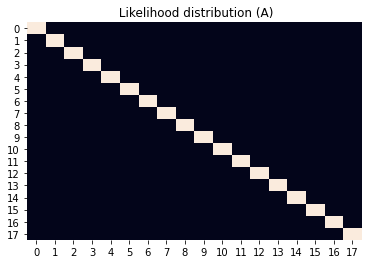

In [97]:
plot_likelihood(ours_v3_3.agent.A[0])

In [98]:
i = print_transitions(ours_v3_3.agent.B[0], actions)

          LEFT
    prev_s   
       0      1      2      3      4      5      6      7      8      9   \
0   0.586  0.128  0.575  0.133  0.074  0.144  0.143  0.133  0.126  0.139   
1   0.022  0.049  0.020  0.037  0.035  0.044  0.043  0.038  0.040  0.040   
2   0.036  0.071  0.031  0.073  0.324  0.076  0.075  0.079  0.077  0.069   
3   0.022  0.045  0.022  0.046  0.030  0.044  0.041  0.036  0.040  0.040   
4   0.021  0.040  0.019  0.040  0.031  0.042  0.038  0.040  0.044  0.040   
5   0.026  0.057  0.027  0.055  0.037  0.046  0.052  0.050  0.052  0.047   
6   0.030  0.064  0.030  0.062  0.047  0.058  0.059  0.056  0.060  0.064   
7   0.018  0.046  0.019  0.038  0.034  0.044  0.041  0.038  0.044  0.043   
8   0.023  0.038  0.020  0.049  0.035  0.047  0.039  0.045  0.046  0.049   
9   0.026  0.054  0.032  0.054  0.045  0.061  0.056  0.067  0.059  0.064   
10  0.024  0.049  0.026  0.051  0.035  0.043  0.050  0.044  0.046  0.052   
11  0.027  0.052  0.028  0.063  0.047  0.052  0.058  0.067 

In [ ]:
ours_v3_3.agent.prev_actions

[array([0.]),
 array([2.]),
 array([3.]),
 array([0.]),
 array([1.]),
 array([2.]),
 array([1.]),
 array([1.]),
 array([2.]),
 array([3.]),
 array([0.]),
 array([0.]),
 array([3.]),
 array([3.]),
 array([0.]),
 array([1.]),
 array([3.]),
 array([1.]),
 array([3.]),
 array([2.]),
 array([1.]),
 array([3.]),
 array([1.])]

In [99]:
pose
# ours_v3_3.current_pose

(2, 1)

In [ ]:
ours_v3_3.agent.qs[0].round(3)

array([0., 0., 0., 0., 0., 0., 1., 0., 0.])

In [ ]:
qs_hist = ours_v3_3.agent.qs_hist[-2:]
prior = np.pad(qs_hist[-2][0], (0, max(len(qs_hist[-2][0]), len(qs_hist[-1][0])) - len(qs_hist[-2][0])), mode='constant')
prior.round(3)

array([0., 1., 0., 0., 0.])

In [ ]:
qs_hist = ours_v3_3.agent.qs_hist[:]
max_length = max(len(arr[0]) for arr in qs_hist)
qs_hist = [np.pad(arr[0], (0, max_length - len(arr[0])), mode='constant') for arr in qs_hist]

# prior = qs_hist[-2]
# print(np.array(qs_hist).round(3))
max_indices = np.argmax(qs_hist, axis=1)
print(max_indices)


[0 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 0 1 0 0 1 1 0 1 1 0 0 0 0 0 0 1 1
 1 1 1 1]


In [ ]:
from ours.pymdp.maths import spm_dot

prior = spm_dot(ours_v3_3.agent.B[0][:, :, int(ours_v3_3.agent.prev_actions[-2])], qs_hist[-1])
prior.round(3)

array([0.   , 0.003, 0.004, 0.002, 0.001, 0.002, 0.005, 0.004, 0.003,
       0.002, 0.529, 0.424, 0.003, 0.002, 0.004, 0.003, 0.005, 0.003])

### Ours goal

In [ ]:
ours_v3_3 = load_object("/home/idlab332/workspace/higher_level_nav/results/grid_3x3/ours_v3/ours_v3_2024-01-29-14-40-42/ours_v3.pkl")

In [ ]:
preferred_ob = [4, -1]
ours_v3_3.goal_oriented_navigation(obs = preferred_ob.copy())

In [ ]:
# # #RUN oursV3.3 GOAL
action_hist = []
T= 10
pose = start_pose
c_ob = []
p_ob = []
for t in range(0,T):
    print(' __ ')
    print('time', t, 'believed Qs:',ours_v3_3.get_current_belief()[0].round(3))
    action, _ = ours_v3_3.infer_action()
    action_hist.append(action)
    obs, _,_,_ = env.step(action, pose)
    ob, pose = obs
    c_ob.append(ob)
    p_ob.append(pose)
    next_possible_actions = env.get_next_possible_motions(pose, no_stay = True)
    print('action taken:',int(action),'pose:',pose,',ob:', ob)
    print('next_possible_actions',next_possible_actions)
    ours_v3_3.agent_step_update(action,[ob,pose],next_possible_actions)
    
    if (ob == preferred_ob[0] and action == actions['STAY']) \
        or (preferred_ob[0] == np.all(c_ob[-3:]) and pose == np.all(p_ob[-3:])) :
        print('Goal reached')
        break

### More visualisation

<AxesSubplot:>

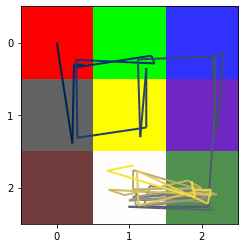

In [101]:
plot_path_in_map(env, start_pose, action_hist[:])

In [102]:
ours_v3_3.get_agent_state_mapping()

{(0, 0): {'state': 0, 'ob': 8, 'ob2': 0},
 (1, 0): {'state': 6, 'ob': 5, 'ob2': 1},
 (0, 1): {'state': 2, 'ob': 1, 'ob2': 2},
 (1, 1): {'state': 16, 'ob': 4, 'ob2': 3},
 (0, 2): {'state': 4, 'ob': 2, 'ob2': 4},
 (1, 2): {'state': 17, 'ob': 3, 'ob2': 5},
 (2, 2): {'state': 16, 'ob': 8, 'ob2': 6},
 (2, 1): {'state': 9, 'ob': 7, 'ob2': 7}}

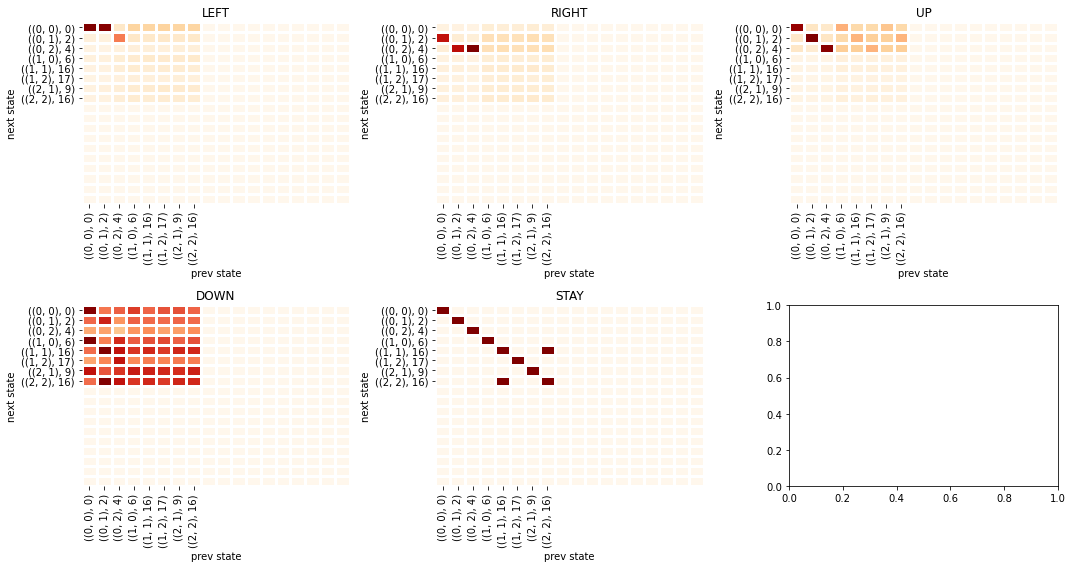

In [103]:
plot_transition_detailed(ours_v3_3.get_B(), actions, ours_v3_3.get_agent_state_mapping(), desired_state_mapping, 'ours_v3_3', plot=True, save=False)

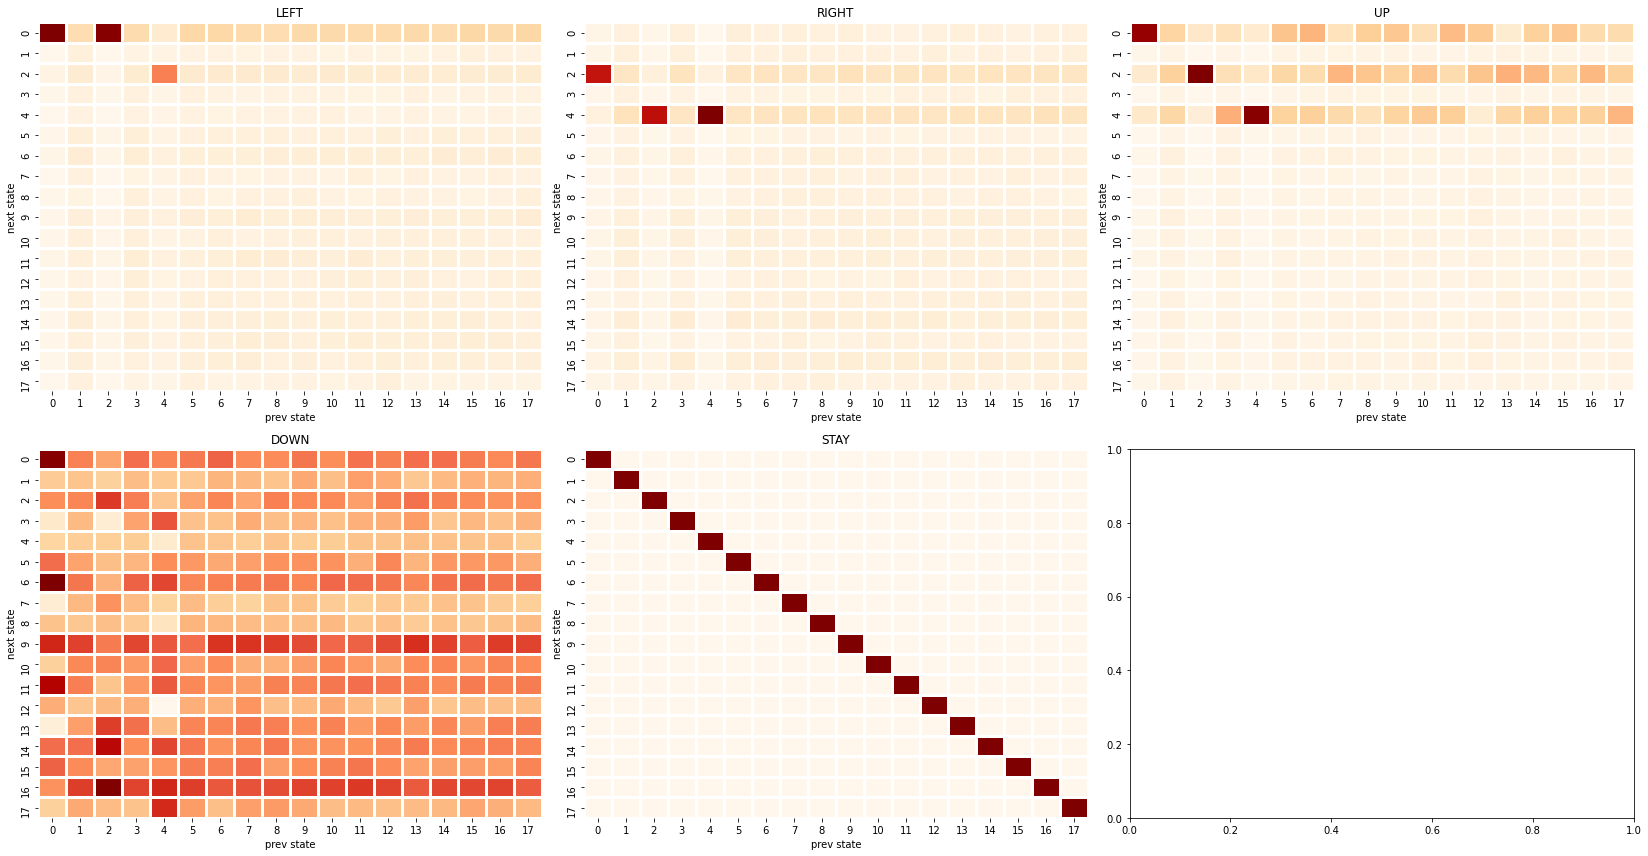

In [104]:
a = plot_transition(ours_v3_3.get_B(), actions)

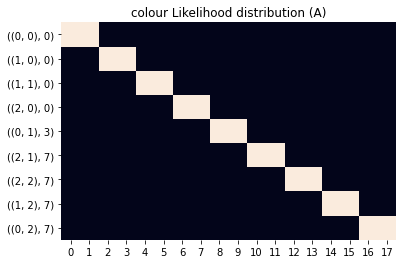

In [91]:
plot_likelihood(ours_v3_3.get_A()[0], state_mapping=ours_v3_3.get_agent_state_mapping(), tittle_add='colour')

In [ ]:
a = print_transitions(ours_v3_3.get_B(), actions)

          LEFT
    prev_s   
       0      1      2      3    4
0  0.897  0.112  0.230  0.208  0.2
1  0.096  0.875  0.230  0.208  0.2
2  0.003  0.002  0.230  0.208  0.2
3  0.002  0.001  0.172  0.208  0.2
4  0.002  0.010  0.138  0.167  0.2
          RIGHT
    prev_s   
       0      1      2      3    4
0  0.589  0.046  0.230  0.208  0.2
1  0.397  0.946  0.230  0.208  0.2
2  0.006  0.004  0.230  0.208  0.2
3  0.004  0.003  0.172  0.208  0.2
4  0.003  0.002  0.138  0.167  0.2
          UP
    prev_s   
       0      1      2      3    4
0  0.182  0.069  0.230  0.208  0.2
1  0.794  0.925  0.230  0.208  0.2
2  0.020  0.003  0.230  0.208  0.2
3  0.002  0.002  0.172  0.208  0.2
4  0.002  0.001  0.138  0.167  0.2
          DOWN
    prev_s   
       0      1      2      3    4
0  0.838  0.536  0.230  0.208  0.2
1  0.142  0.459  0.230  0.208  0.2
2  0.003  0.002  0.230  0.208  0.2
3  0.016  0.002  0.172  0.208  0.2
4  0.001  0.001  0.138  0.167  0.2
          STAY
    prev_s   
     0    1    2

In [ ]:
from pathlib import Path
qs_hist = ours_v3_3.agent.qs_hist[:]
max_length = max(len(arr[0]) for arr in qs_hist)
qs_hist = [np.pad(arr[0], (0, max_length - len(arr[0])), mode='constant') for arr in qs_hist]

# prior = qs_hist[-2]
# print(np.array(qs_hist).round(3))
states = np.argmax(qs_hist, axis=1)
v = np.unique(states)
T = ours_v3_3.agent.B[0][:,v,:][v,:]
A = T.sum(2)
div = A.sum(1, keepdims=True)
A /= (div + 0.0001)
A[A < 0.01] = 0
print(A)
#state_map = ours_v3_3.get_agent_state_mapping()
state_map = {pose: {'state':1,'ob':1}}
plot_cscg_graph(A, c_obs, v, n_clones, state_map, Path(''), env.rooms_colour_map)

[[0.8211703  0.17880628]
 [0.25366726 0.74631499]]


NameError: name 'c_obs' is not defined

## CSCG

In [ ]:
def train_cscg(model, observations, actions):
    #len(observations) > len(actions), no matter because this algo considers only actions length 
    if isinstance(observations[0], np.ndarray) :
        poses_idx = model.from_pose_to_idx(observations[:,1])
        observations[:,1] = poses_idx
    elif isinstance(observations[0], tuple):
        poses_idx = model.from_pose_to_idx(observations)
        observations = poses_idx
    
    actions = np.array(actions).flatten().astype(np.int64)

    progression = model.learn_em_T(observations, actions, n_iter=200)  # Training
    # # refine learning
    model.pseudocount = 0.0001
    model.learn_viterbi_T(observations, actions, n_iter=100)
    return model, progression

In [ ]:
n_emissions = rooms.shape[0]* rooms.shape[1] #rooms.max() + 1
n_clones = np.ones(n_emissions, dtype=np.int64) * 10
n_actions = max(list(actions.values()))
x = np.array([0])
a = np.array([n_actions])
chmm  =  CHMM(n_clones=n_clones, pseudocount=0.002, \
                x=x, a=a, seed=42, set_stationary_B=True) 

In [ ]:
#CSCG EXPLORATION
T=300
ob = env.get_ob_given_p(start_pose)
c_obs, a = [np.array([ob],dtype=np.int64), np.array([], dtype=np.int64)]
poses = [start_pose]
pose = start_pose
test = []
for t in range(0,T):
    next_possible_actions = env.get_next_possible_motions(pose, no_stay=False)
    
    # print('p next actions', pose, next_possible_actions)
    next_possible_actions = [0,1,2,3]
    #print('observations', [ob, pose])
    action, _ = chmm.infer_action(next_possible_actions = next_possible_actions, observation=[ob, pose], random_policy=False)
    test.append(chmm.pose_mapping.index(pose))
    obs, _,_,_ = env.step(action, pose)
    ob, pose = obs
    c_obs =np.append(c_obs,ob)
    a= np.append(a,action)
    poses.append(pose)

test.append(chmm.pose_mapping.index(pose))

observations = np.array([np.array([c, p], dtype=object) for c, p in zip(c_obs, poses)])
train_cscg(chmm, observations, a)
# progression = chmm.learn_em_T(x, a, n_iter=200)  # Training

# # refine learning
# chmm.pseudocount = 0.0001

# chmm.learn_viterbi_T(x, a, n_iter=100)


  2%|▏         | 2/100 [00:00<00:00, 206.11it/s, train_bps=0.0231]


(<cscg.cscg.CHMM at 0x7ff7225a87c0>,
 [3.1429594,
  0.25128984,
  0.24834754,
  0.24782287,
  0.24721463,
  0.24638027,
  0.24522917,
  0.2436531,
  0.24153051,
  0.23875092,
  0.23525053,
  0.23102024,
  0.22607447,
  0.22048776,
  0.21445455,
  0.20814884,
  0.20152923,
  0.19454837,
  0.1874338,
  0.18045644,
  0.17370898,
  0.16721998,
  0.16096215,
  0.15491854,
  0.149144,
  0.14367892,
  0.13874419,
  0.13438854,
  0.13013352,
  0.12575422,
  0.12149164,
  0.117345996,
  0.113134645,
  0.10897957,
  0.10503559,
  0.101273604,
  0.097507454,
  0.09375613,
  0.09046101,
  0.087865,
  0.085760385,
  0.0841155,
  0.08306615,
  0.082492284,
  0.08212058,
  0.08173792,
  0.081262775,
  0.08064256,
  0.07982637,
  0.07882731,
  0.07783977,
  0.07704411,
  0.07627823,
  0.07540871,
  0.07442563,
  0.07332999,
  0.07211964,
  0.07076707,
  0.06924958,
  0.067589186,
  0.06567868,
  0.06341694,
  0.06105996,
  0.059165023,
  0.058016956,
  0.057237282,
  0.056577764,
  0.05618787,
  0.055

In [ ]:

poses_idx = chmm.from_pose_to_idx(poses)
np.all(np.equal(np.array(test), poses_idx))


True

In [ ]:
with open("figures/cscg/cscg_test.pkl", "wb") as outp:
    pickle.dump(chmm, outp, pickle.HIGHEST_PROTOCOL)

In [ ]:
chmm.get_agent_state_mapping()

{(0, 0): {'state': 3, 'ob': 0, 'ob2': 0},
 (1, 0): {'state': 13, 'ob': 2, 'ob2': 1},
 (0, 1): {'state': 22, 'ob': 0, 'ob2': 2},
 (2, 0): {'state': 33, 'ob': 3, 'ob2': 3},
 (2, 1): {'state': 48, 'ob': 3, 'ob2': 4},
 (2, 2): {'state': 53, 'ob': 3, 'ob2': 5},
 (1, 2): {'state': 62, 'ob': 4, 'ob2': 6},
 (0, 2): {'state': 74, 'ob': 1, 'ob2': 7},
 (1, 1): {'state': 82, 'ob': 0, 'ob2': 8}}

In [ ]:
chmm.get_agent_state_mapping()

{(0, 0): {'state': 3, 'ob': 0, 'ob2': 0},
 (1, 0): {'state': 13, 'ob': 4, 'ob2': 1},
 (0, 1): {'state': 22, 'ob': 1, 'ob2': 2},
 (2, 0): {'state': 33, 'ob': 8, 'ob2': 3},
 (2, 1): {'state': 48, 'ob': 7, 'ob2': 4},
 (2, 2): {'state': 56, 'ob': 6, 'ob2': 5},
 (1, 2): {'state': 62, 'ob': 3, 'ob2': 6},
 (0, 2): {'state': 74, 'ob': 2, 'ob2': 7},
 (1, 1): {'state': 82, 'ob': 5, 'ob2': 8}}

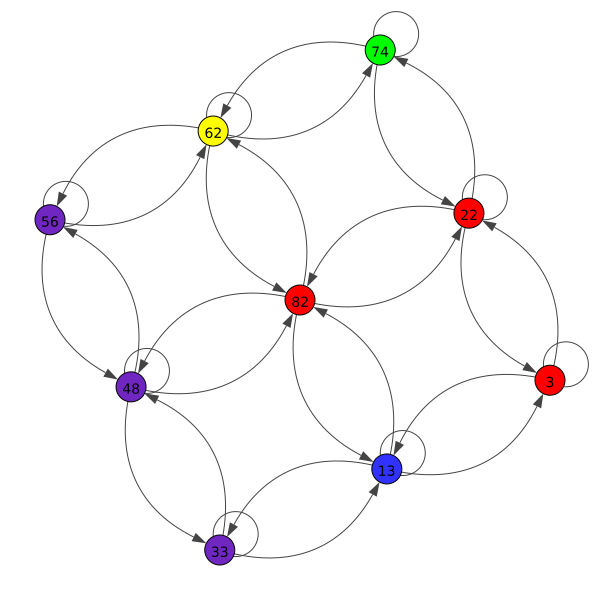

In [ ]:
from pathlib import Path
if len(chmm.states) == 0:
    print('here')
    # poses_idx = from_pose_to_idx(chmm, poses)
    # obs = np.array(poses_idx).flatten().astype(np.int64)
    # a = np.array(a[1:]).flatten().astype(np.int64)
    # states = chmm.decode(x,a)[1]
else:
    states = chmm.states
v = np.unique(states)
T = chmm.C[:, v][:, :, v]
A = T.sum(0)
div = A.sum(1, keepdims=True)
A /= (div + 0.0001)

agent_state_mapping = chmm.get_agent_state_mapping(observations,a,poses)
plot_cscg_graph(A,observations,v, chmm.n_clones, agent_state_mapping , Path(''), env.rooms_colour_map)

<AxesSubplot:>

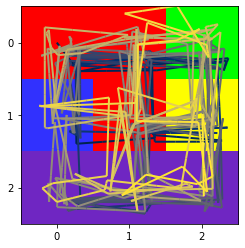

In [ ]:
plot_path_in_map(env, start_pose, a[:])

In [ ]:
agent_state_mapping = chmm.get_agent_state_mapping()
agent_state_mapping


In [ ]:
if len(chmm.states) == 0:
    states = chmm.decode(x,a[1:])[1]
else:
    states = chmm.states
    v = np.unique(states)
    T = chmm.C[:, v][:, :, v]
    A = T.sum(0)
    div = A.sum(1, keepdims=True)
    A /= (div + 0.0001)
cwd = Path.cwd()
graph = plot_cscg_graph(A, x, v, chmm.n_clones,  cwd, cmap)

graph


In [ ]:
chmm.get_agent_state_mapping(x,a,poses)

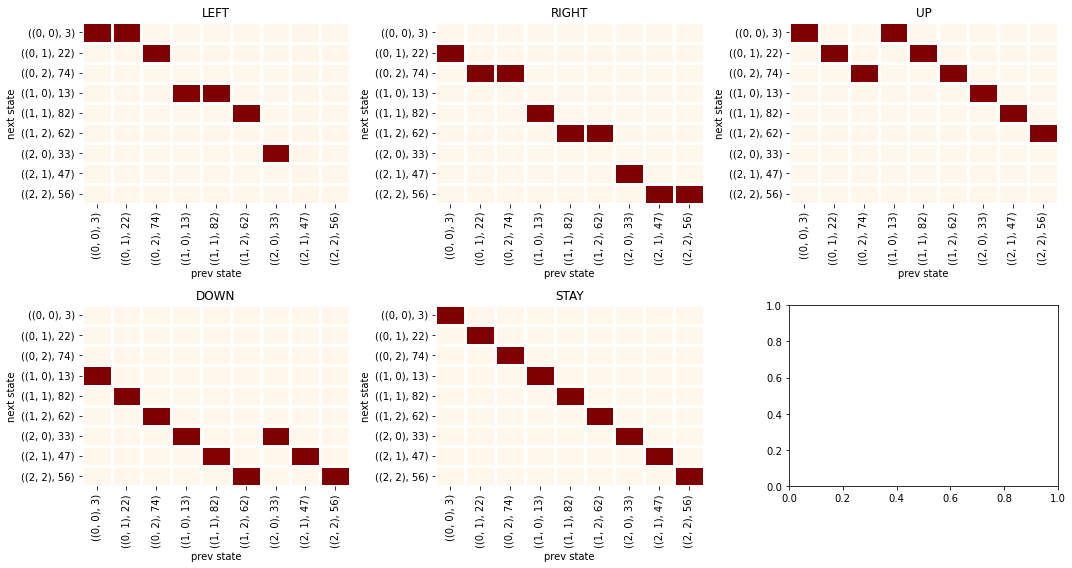

<module 'matplotlib.pyplot' from '/home/idlab332/anaconda/lib/python3.9/site-packages/matplotlib/pyplot.py'>

In [ ]:
n_states =  9#chmm.get_n_states()
plot_transition_detailed_resized(chmm.get_B(), actions, chmm.get_agent_state_mapping(observations,a,poses), \
                             desired_state_mapping, plot=True)

In [ ]:
tr = print_transitions(chmm.get_B(), actions)

In [ ]:
preferred_ob = [4, -1]
chmm = load_object("/home/idlab332/workspace/higher_level_nav/results/grid_3x3/cscg/cscg_2024-01-26-17-24-46/cscg.pkl")


chmm.goal_oriented_navigation(obs = preferred_ob.copy())

In [ ]:
from ours.pymdp import utils
from ours.pymdp.maths import spm_dot

def infer_action(chmm, **kwargs):
    obs=kwargs.get('obs',-1)
    next_possible_actions = kwargs.get('next_possible_actions',[*range(chmm.n_actions)])
    random = kwargs.get('random_policy', False)
    if random:
        return np.random.choice(next_possible_actions)
    
    prior = chmm.agent.qs[0].copy()
    if chmm.prev_action is not None:
        prior = spm_dot(chmm.agent.B[0][:, :, chmm.prev_action], prior)

    qs = chmm.agent.infer_states([obs])

    action = int(get_action(chmm,qs,next_possible_actions))

    chmm.prev_action = action

    chmm.agent.action = np.array([chmm.prev_action])
    chmm.agent.step_time()

    posterior = chmm.agent.qs[0].copy()
    return action, {
        "qs": chmm.agent.qs[0],
        "bayesian_surprise": utils.bayesian_surprise(posterior, prior),
        }

def get_action(chmm, qs,next_possible_actions):
    # states = np.where(qs[0][:-1] > 1e-4)[0]
    states = np.where(qs[0] > 1e-4)[0]
    pq = qs[0][states]

    plans = []
    n_states = []
    for i, s in enumerate(states):
        # pi_x = np.zeros_like(qs[0][:-1])
        pi_x = np.zeros_like(qs[0])
        pi_x[s] = 1
        #if s not in chmm.preferred_states:
        #if s in chmm.states:
        actions, states = observation_bridge(chmm, pi_x, max_steps=15) #consider preference
    
        if actions[0] == -1:
            pq[i] = 0
        elif states[0] in chmm.states:
            pq[i] = pq[i] * 1.5
        # else:
        #     actions = [-1]  # just go forward if its already in preferred
        #     states = [-1]
        #     pq[i] = 0

        plans.append(actions[0])
        n_states.append(states[0])

    norm = pq.sum() 
    print('plan', plans,'n_states',n_states, 'pq', pq)
    # if norm <= 0:
    #     pq = [1/len(pq)]*len(pq)
    #     action = np.random.choice(next_possible_actions)
    # else:
    pq /= norm
    action = np.random.choice(plans, p=pq)
    return action

def observation_bridge(chmm, belief_over_states, max_steps=100):
    
    # T = chmm.T[:, v][:, :, v][:, :, :]
    ret = forward_mp_all_multiple_states(
        chmm.T.transpose(0, 2, 1),
        belief_over_states,
        chmm.Pi_a,
        chmm.n_clones,
        chmm.preferred_states,
        max_steps,
    )
    
    if ret:
        print('belief_over_states',np.argmax(belief_over_states),'pref state', ret[2] ,'mess_fwd' ,ret[1]  )
        log2_lik, mess_fwd, selected_state = ret
        s_a = backtrace_all(
            chmm.T, chmm.Pi_a, chmm.n_clones, mess_fwd, selected_state
        )
        print('s_a',s_a)
        return s_a
    return [-1], [-1]
    


def backtrace_all(T, Pi_a, n_clones, mess_fwd, target_state):
    """Compute backward messages."""
    states = np.zeros(mess_fwd.shape[0], dtype=np.int64)
    actions = np.zeros(mess_fwd.shape[0], dtype=np.int64)
    n_states = T.shape[1]
    # backward pass
    t = mess_fwd.shape[0] - 1
    actions[t], states[t] = (
        -1,
        target_state,
    )  # last actions is irrelevant, use an invalid value
    for t in range(mess_fwd.shape[0] - 2, -1, -1):
        belief = (
            mess_fwd[t].reshape(1, -1) * T[:, :, states[t + 1]] * Pi_a.reshape(-1, 1)
        )
        a_s = rargmax(belief.flatten())
        actions[t], states[t] = a_s // n_states, a_s % n_states
    return actions, states


def forward_mp_all_multiple_states(
    T_tr, Pi_x, Pi_a, n_clones, target_states, max_steps
):
    """Log-probability of a sequence, and optionally, messages"""
    # forward pass
    t, log2_lik = 0, []
    message = Pi_x
    p_obs = message.max()
    assert p_obs > 0
    message /= p_obs
    log2_lik.append(np.log2(p_obs))
    mess_fwd = []
    mess_fwd.append(message)
    T_tr_maxa = (T_tr * Pi_a.reshape(-1, 1, 1)).max(0)
    selected_state = -1
    for t in range(1, max_steps):
        message = (T_tr_maxa * message.reshape(1, -1)).max(1)
        print('message high states', np.where(message > 0.1))
        p_obs = message.max()
        print('t',t, 'message', p_obs, message)
        if p_obs > 0:
            message /= p_obs
            log2_lik.append(np.log2(p_obs))
            mess_fwd.append(message)
            break_out = False
            print('message high states', np.where(message > 0.2), np.any(message != [message[0]]*len(message)))
            for target_state in target_states:
                
                #if target state reached if possible next state AND if the proba is not equally distributed among ALL states
                if message[target_state] > 0 : 
                    selected_state = target_state
                    break_out = True
                    print('break out', selected_state)
                    break
            if break_out:
                break
        else:
            return False

    else:
        return False
    return np.array(log2_lik), np.array(mess_fwd), selected_state

def rargmax(x):
    # return x.argmax()  # <- favors clustering towards smaller state numbers
    return np.random.choice((x == x.max()).nonzero()[0])

In [ ]:
def goal_reached(model, action , c_obs, p_obs, actions):
    if (c_obs[-1] == model.preferred_ob[0] and action == actions['STAY']) :
        print('Goal reached')
        return 1
    elif np.array_equal([model.preferred_ob[0]] * 3,c_obs[-3:]) and np.array_equal([p_obs[-1]]*3 ,p_obs[-3:]):
        print('Goal reached')
        return 2
    return 0


In [ ]:
#CSCG GOAL 
# chmm = load_object("figures/cscg/cscg_test.pkl")

chmm.goal_oriented_navigation(obs = preferred_ob.copy())
obs,_ = env.reset((0,0))
ob, pose = obs
print('start ob', ob)
x, a = [np.array([ob],dtype=np.int64), np.array([], dtype=np.int64)]
poses = [start_pose]
pose = start_pose
T = 15
for t in range(0,T):
    print()
    print('my t', t)
    next_possible_actions = env.get_next_possible_motions(pose, no_stay=False)
    print('p next actions', pose, next_possible_actions)
    # next_possible_actions = [0,1,2,3,4]
    action, _ = chmm.infer_action(obs=ob, random_policy=False)
    print('pose', pose, 'action chosen:', action)
    obs, _,_,_ = env.step(action, pose)
    ob, pose = obs
    x =np.append(x,ob)
    a= np.append(a,action)
    poses.append(pose)

    if goal_reached(chmm, action , x, poses, actions) >0:
        break

In [ ]:
plot_path_in_map(env, start_pose, a[:])